In [4]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#载入数据
dir_path = 'E:/HuangShan/CleanData'
files = os.listdir(dir_path)
data = []
fileMax = 100
fileCnt = 0
for datafile in files:
    path = dir_path + '/' + datafile
    frame = pd.read_csv(path, encoding='utf-8')                 
    data.append(frame)
    fileCnt += 1
    if fileCnt >= fileMax:
        break
data = pd.concat(data, ignore_index = False)
data['date'] = pd.to_datetime(data.date)
data['tw_all'] = ((data.date-data.date.min())/pd.Timedelta(days=1)*(24*60/tw_span)+data.tw).astype(int)
del data['Unnamed: 0']
data['mac6'] = data.mac.str[:6]
data = pd.merge(data, vendor, on='mac6')
data = pd.merge(data, ap_reduce, on='ap_seq')
m_data = data[data.mobile==True]
s = ['2','6','A','E']
data['randMac'] = data.mac.str[1].isin(s)

In [24]:
m_data = m_data[(m_data.tw_all < 3168)&(m_data.tw_all>2880)]

In [67]:
#去掉只在新国线或索道下站出现的mac (mac数量从184016下降到151251)
temp = m_data[m_data.ap_seq.isin([1,2,3,14,15,18])==False]
mac = temp.groupby(['mac','date']).apply(len).reset_index(name='cnt').groupby('mac').apply(len).reset_index(name='day_cnt')
location = temp.groupby(['mac','ap_seq']).apply(len).reset_index(name='cnt').groupby('mac').apply(len).reset_index(name='location_cnt')
mac = pd.merge(mac, location, on='mac')
g_data = m_data[m_data.mac.isin(mac.mac)]
g_data = g_data.sort_values(['mac','tw_all'])

In [68]:
tw_min = g_data.groupby('mac')['tw'].min()
tw_max = g_data.groupby('mac')['tw'].max()
tw_span = (tw_max-tw_min).apply(lambda x:x+1).reset_index(name = 'span')
g_data = pd.merge(g_data, tw_span)
g_data.head(20)

,mac,tw,date,cnt,ssid,ap_seq,tw_all,mac6,vendor,mobile,area_id,span
0,00166D148829,88,2017-01-29,3,.,18,2968,00166D,Yulong,True,5,99
1,00166D148829,89,2017-01-29,1,.,18,2969,00166D,Yulong,True,5,99
2,00166D148829,90,2017-01-29,5,.,18,2970,00166D,Yulong,True,5,99
3,00166D148829,100,2017-01-29,3,.,18,2980,00166D,Yulong,True,5,99
4,00166D148829,108,2017-01-29,3,.,11,2988,00166D,Yulong,True,2,99
5,00166D148829,126,2017-01-29,5,.,8,3006,00166D,Yulong,True,1,99
6,00166D148829,127,2017-01-29,3,.,8,3007,00166D,Yulong,True,1,99
7,00166D148829,134,2017-01-29,5,.,16,3014,00166D,Yulong,True,4,99
8,00166D148829,135,2017-01-29,11,.,16,3015,00166D,Yulong,True,4,99
9,00166D148829,136,2017-01-29,7,.,16,3016,00166D,Yulong,True,4,99


In [72]:
t_data = g_data[:]
t_data.loc[:,['tw']] = 1
stay_cnt = t_data.groupby([t_data['mac'], t_data['span'], t_data['ap_seq']])['tw'].apply(len).reset_index(name='stay')
for i in range(20):
    stay_cnt['ap' + str(i)] = stay_cnt[stay_cnt.ap_seq == i].stay

<IPython.core.display.Javascript object>


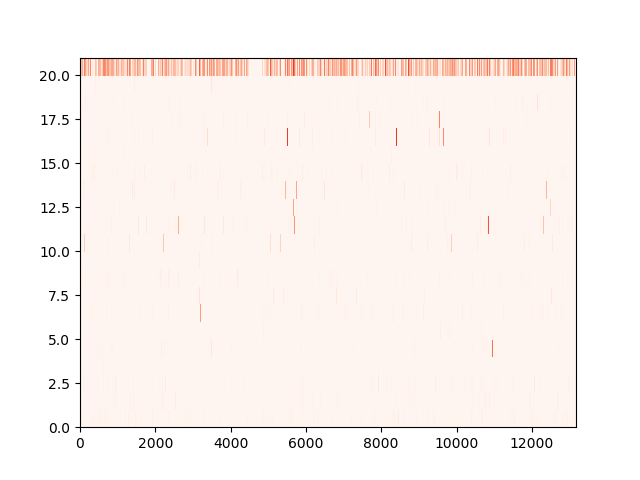

In [107]:
stay_square = stay_cnt.groupby([stay_cnt['mac'],stay_cnt['span']])['ap0','ap1','ap2','ap3','ap4','ap5',
                                     'ap6','ap7','ap8','ap9','ap10','ap11','ap12',
                                     'ap13','ap14','ap15','ap16','ap17','ap18',
                                     'ap19'].sum().fillna(0).reset_index()
stay_square['ap20'] = stay_square.span - stay_square.iloc[:,2:22].apply(lambda x:x.sum(), axis=1)
stay_square = stay_square[stay_square.ap20 >= 0]
X_train = stay_square.iloc[:,2:23].as_matrix(columns=None).T
plt.pcolor(X_train,cmap=plt.cm.Reds)
plt.show()

<IPython.core.display.Javascript object>


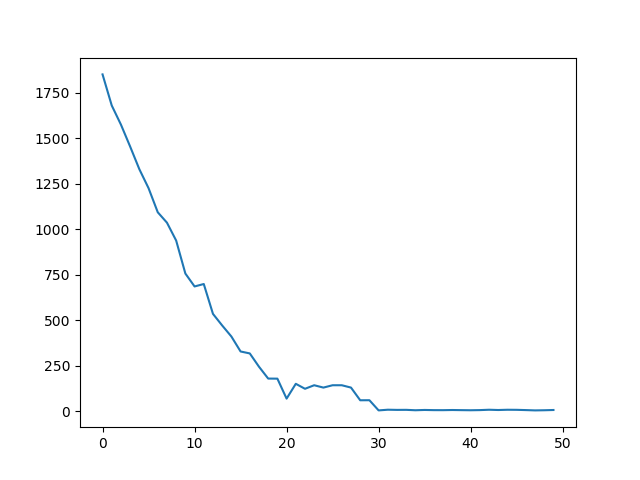

In [93]:
from sklearn.decomposition import NMF
def learn_curve(X, max_feature=50):
    error = []
    for i in range(max_feature):
        model = NMF(n_components=i+1, init='random', random_state=0)
        model.fit(X)
        error.append(model.reconstruction_err_)
    error = np.array(error)
    plt.plot(error)
    
learn_curve(X_train)

<IPython.core.display.Javascript object>


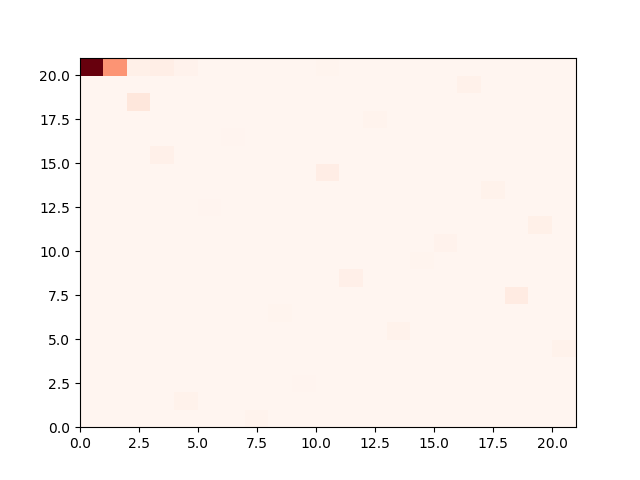

In [112]:
model = NMF(n_components=21, init='random', random_state=0)
model.fit(X_train)
W = model.fit_transform(X_train)
plt.pcolor(W,cmap=plt.cm.Reds)
plt.show()

In [109]:
W

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.60388842e-01,   0.00000000e+00,   0.00000000e+00,
          3.38895679e-01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.02416481e-05,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   3.36904750e-07,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.08651466e-06,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,